# TSL Timing Screen Screenshot Grabber


A simple script to grab a screenshot of a TSL Timing screen.

*Note that the recipe is easily generalised to grab arbitrary webpages.*

In [1]:
#Inspired by: https://www.kaggle.com/dierickx3/kaggle-web-scraping-via-headless-firefox-selenium
#from webdriverdownloader import GeckoDriverDownloader
#gdd = GeckoDriverDownloader()
#geckodriver, geckobin = gdd.download_and_install("v0.23.0")

#Alternatively, we can install as part of the container build process

## Set up a browser instance

We can create a headless browser (one that doesn't need to open in a window that we can see) that we can load pages into and grab screenshots from. As we are running an actual browser, if the web page is being updated via a websocket connection, our remotely launched browser will be being updated with the socket connection data.

So once we lauch our browser onto a timing screen, we can just keep referencing the browser to get the latest view of the page...

In [2]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

options = Options()
options.headless = True

#If we need to set the path to geck, we can...
#browser = webdriver.Firefox(executable_path=geckobin, options=options)

browser = webdriver.Firefox(options=options)

Set the URL of the page you want to grab the screenshot for:

In [3]:
url = "https://livetiming.tsl-timing.com/191231"
url = 'https://livetiming.tsl-timing.com/191209'
url='https://livetiming.tsl-timing.com/191431'#brscc april 6
#url='https://livetiming.tsl-timing.com/191403' #btcc april 6

Some web pages take time to load. For example, the TSL live timing screens are likely to show a spinny thing when a timing screen page is first loaded.

*The TSL timing screen works by loading a page container, then sets up a data connection via a web socket to retrieve the actual timing updates. If we are just grabbing a screenshot of the rendered timing screen, we need to make sure we wait long enough for the spinny thing to disappear and for the table to be rendered.*

In [4]:
#desiredId = 'tablebody' #The HTML id of a tag we want to be visible before we grab the page screenshot
undesiredId = 'loading' #The HTML tag of an element we want to be invisible before we grab the page screenshot

Set the name of the image file you want to save the screenshot to:

In [5]:
outfile = 'screenshot.png'

Now we can grab the screenshot:

In [6]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

In [7]:
#Set a default screensize...
#There are other ways of setting up the browser so that we can grab the full browser view,
#even long pages that would typically require scrolling to see completely
browser.set_window_size(800, 400)
browser.get(url)

#EC.visibility_of_element_located
#EC.presence_of_element_located
#EC.invisibility_of_element_located

#Let's wait for the spinny thing to disappear...
element = WebDriverWait(browser, 10).until( EC.invisibility_of_element_located((By.ID, undesiredId)))

#Save the page
browser.save_screenshot( outfile )
print('screenshot saved to {}'.format(outfile))

screenshot saved to screenshot.png


## Tabs

- Classification: current ranking
- Tracking: track map
- Weather:
- Statistics: fasest laps etc

Preview the captured page:

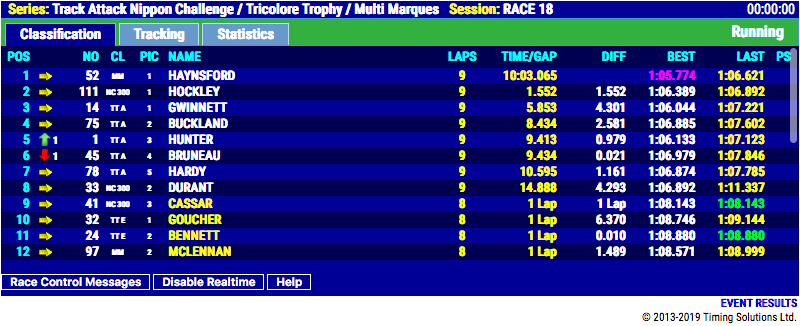

In [8]:
from IPython.display import Image
Image(outfile)

We can also grab other tabs...

screenshot saved to screenshot_Classification.png


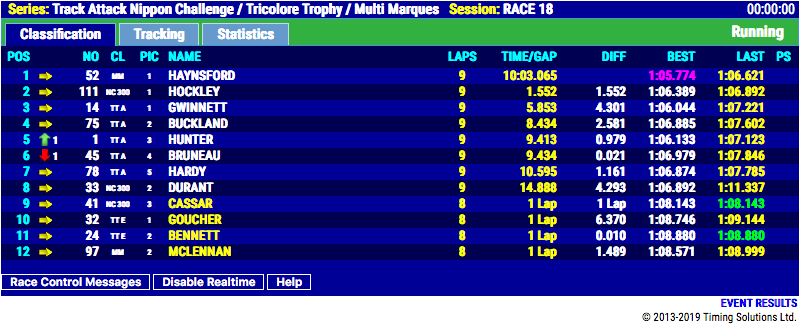

In [9]:
#Classification, Weather, Statistics

tabId = "Classification"
element = browser.find_element_by_id(tabId)
element.click()
element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))

ofn = '{}_{}.png'.format(outfile.replace('.png',''),tabId)

#Save the page
browser.save_screenshot( ofn )
print('screenshot saved to {}'.format(ofn))
Image(ofn)

### Grab some metadata

The timing screen includes information about the race series and the session the timing screen relates to. We can pull that data out of the timing screen to act as metadata.

In [10]:
#https://stackoverflow.com/a/12150013/454773
from selenium.common.exceptions import NoSuchElementException

def check_exists_by_xpath(driver, xpath):
    try:
        driver.find_element_by_xpath(xpath)
    except NoSuchElementException:
        return False
    return True

def text_value_from_xpath(driver, xpath):
    try:
        el = driver.find_element_by_xpath(xpath)
    except NoSuchElementException:
        return None
    return el.text

#check_exists_by_xpath(browser, '//*[@id="currentflag"]')

In [11]:
#Let's use the classification screen as our "base" screen
tabId='Classification'
element = browser.find_element_by_id(tabId)
element.click()
element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))


Get the series name:

In [12]:
series_path='//*[@id="seriesName"]/span[2]'

series = text_value_from_xpath(browser, series_path)
series

'Track Attack Nippon Challenge / Tricolore Trophy / Multi Marques'

And the session:

In [13]:
session_path = '//*[@id="sessionName"]/span[2]'
session = text_value_from_xpath(browser, session_path )
session

'RACE 18'

We could use this information to give us meaningful filenames when we save timing screen images or data.

In [14]:
#Red flag
#//*[@id="currentflag"]
flag_path='//*[@id="currentflag"]'
flag = text_value_from_xpath(browser, flag_path )
flag

'Running'

In [15]:
sessionTime_path ='//*[@id="sessionTime"]'
sessionTime = text_value_from_xpath(browser, sessionTime_path )
sessionTime

'00:00:00'

### Grabbing Images of the Timing Screen

We can create a simple function to use *selenium* to grab png screenshots of a particular tab on the timing screen.

In [16]:
def getPageByTab(browser,url, tabId='Classification', ofn=None):
    ''' Simple function to view a particular tab within a TSL timing screen. '''

    element = browser.find_element_by_id(tabId)
    element.click()
    element = WebDriverWait(browser, 10).until( EC.visibility_of_element_located((By.ID, tabId)))

    ofn = ofn if ofn is not None else '{}_{}.png'.format(outfile.replace('.png',''),tabId)

    #Save the page
    browser.save_screenshot( ofn )
    print('screenshot saved to {}'.format(ofn))
    display(Image(ofn))
    return ofn

screenshot saved to screenshot_Classification.png


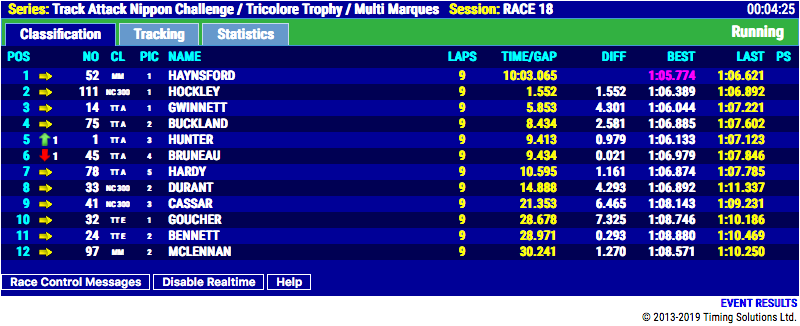

'screenshot_Classification.png'

In [18]:
#url = 'https://livetiming.tsl-timing.com/191209'
getPageByTab(browser, url, 'Classification')

We could create a meaningful filename from the series and session metadata. For example:

screenshot saved to Track Attack Nippon Challenge _ Tricolore Trophy _ Multi Marques_RACE 18.png


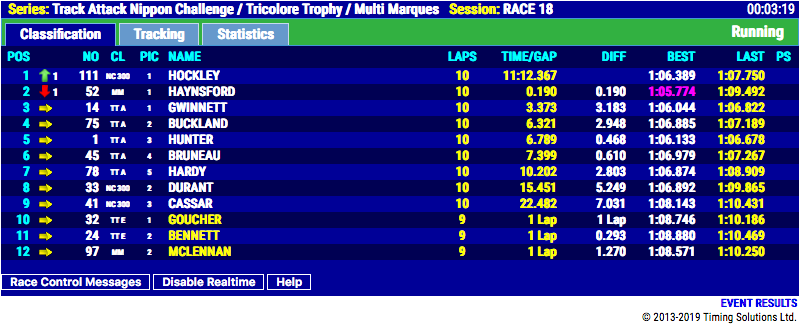

'Track Attack Nippon Challenge _ Tricolore Trophy _ Multi Marques_RACE 18.png'

In [23]:
#get file name
fn = '{}_{}.png'.format(series.replace('/','_'), session.replace('/','_') )

getPageByTab(browser, url, 'Classification', fn)

We can get also access to the actual HTML via the element's `innerHTML()` attribute:

`el.get_attribute('innerHTML')`

If we grab the `<table>` element, this actually returns the contents contained *within* the table element, so we would need to recreate the outer `<table>` tag before we try to scrape the table data into a *pandas* dataframe. If we grab a `<div>` element that contains the table, we can scrape it directly into a *pandas* dataframe.

In [24]:
#classification data
xpath = '//*[@id="ResultsTableContainer"]'
el = browser.find_element_by_xpath(xpath)

In [25]:
import pandas as pd

df = pd.read_html( el.get_attribute('innerHTML'))[0].dropna(axis=1,how='all')
df.rename(columns={'Time/Gap':'TimeGap',
                   'Unnamed: 1':'Penalties'}, inplace=True)
df.head()

,Pos,Penalties,No,Cl,PIC,Name,Laps,TimeGap,Diff,Best,Last,PS
0,1,Penalties +0 seconds +0 position +0 lap +0...,111,NC 300,1,HOCKLEY Honda Civic,10,11:12.367,NaN,1:06.389,1:07.750,NaN
1,2,Penalties +0 seconds +0 position +0 lap +0...,52,MM,1,HAYNSFORD Mazda RX-8,10,0.190,0.190,1:05.774,1:09.492,NaN
2,3,Penalties +0 seconds +0 position +0 lap +0...,14,TT A,1,GWINNETT Renault Clio,10,3.373,3.183,1:06.044,1:06.822,NaN
3,4,Penalties +0 seconds +0 position +0 lap +0...,75,TT A,2,BUCKLAND Renault Clio,10,6.321,2.948,1:06.885,1:07.189,NaN
4,5,Penalties +0 seconds +0 position +0 lap +0...,1,TT A,3,HUNTER Renault Clio,10,6.789,0.468,1:06.133,1:06.678,NaN


In [26]:
df.dtypes

Pos            int64
Penalties     object
No             int64
Cl            object
PIC            int64
Name          object
Laps           int64
TimeGap       object
Diff          object
Best          object
Last          object
PS           float64
dtype: object

In [46]:
classification_table = '''
CREATE TABLE "tsl_timing_classification" (
  "Pos" INTEGER,
  "Penalties" TEXT,
  "No" INTEGER,
  "Cl" TEXT,
  "PIC" INTEGER,
  "Name" TEXT,
  "Laps" INTEGER,
  "TimeGap" TEXT,
  "Diff" TEXT,
  "Best" TEXT,
  "Last" TEXT ,
  "PS" FLOAT,
  "S1" TEXT,
  "V1" FLOAT,
  "S2" TEXT,
  "V2" FLOAT,
  "S3" TEXT, 
  "VF" FLOAT,
  PRIMARY KEY (No, Laps, Last)
);
'''

In [50]:
import sqlite3
from sqlite_utils import Database

dbname='testlive6.db'

!rm $dbname
conn = sqlite3.connect(dbname, timeout=10)


#Setup database tables
c = conn.cursor()
c.executescript(classification_table)


DB = Database(conn)
_table = 'tsl_timing_classification'

rm: testlive6.db: No such file or directory


If we grab the classification table with a period sligthly less than that of the fastest sector time, and upsert on the table using the (car number, lap, gap) as a unique key, then we should make sure we capture all the laps and the sector times, though we will need to do a little bit of processing of the multiple rows captured for each driver for each lap. (As the timing screen is live, as the leader goes onto a new lap, every other driver goes at least 1 Lap behind; we have to recover from such things.)

The *(car number, lap, previous lap)* combination should also be unique. (I need to think, would that guarantee we capture section times?).

In [54]:
url = 'https://livetiming.tsl-timing.com/191403'
browser = webdriver.Firefox(options=options)
browser.get(url)

screenshot saved to screenshot_Classification.png


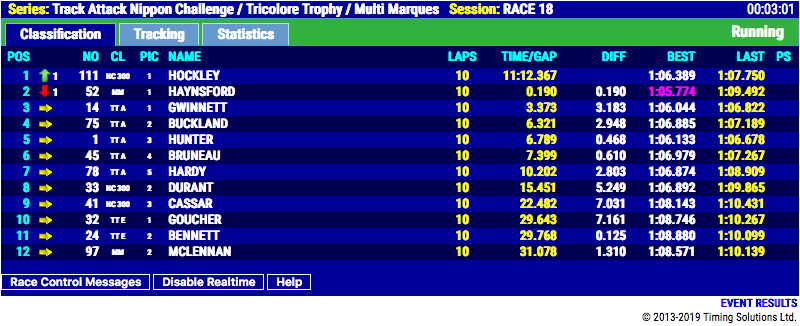

'screenshot_Classification.png'

In [29]:
#should perhap have a wait here to just make sure evrything is loaded...
#Or perhaps better, a guard at end of previous cell
getPageByTab(browser, url, 'Classification')

In [ ]:
import time

xpath = '//*[@id="ResultsTableContainer"]'


#This should really be while not finished
while True:
    #Grab the timing screen
    el = browser.find_element_by_xpath(xpath)
    
    #Parse out the data
    df = pd.read_html( el.get_attribute('innerHTML'))[0].dropna(axis=1,how='all')
    #Tidy up the column names
    df.rename(columns={'Time/Gap':'TimeGap',
                       'Unnamed: 1':'Penalties'}, inplace=True)
    #Upsert the date
    DB[_table].upsert_all(df.to_dict(orient='records'))
    print('.',end='')
    time.sleep(15)
    
#TO DO - also record time stamp; and maybe in another table, flag status vs timestamp

.....

In [33]:
dbname='testlive2.db'

#!rm $dbname
conn = sqlite3.connect(dbname, timeout=10)

q="SELECT * FROM tsl_timing_classification WHERE No=41;"
pd.read_sql(q,conn)

,Pos,Penalties,No,Cl,PIC,Name,Laps,TimeGap,Diff,Best,Last,PS,S1,V1,S2,V2,S3,VF
0,9,Penalties +0 seconds +0 position +0 lap +0...,41,NC 300,3,CASSAR Honda Civic Type R,10,1 Lap,7.031,1:08.143,1:10.431,None,None,None,None,None,None,None
1,9,Penalties +0 seconds +0 position +0 lap +0...,41,NC 300,3,CASSAR Honda Civic Type R,10,22.482,7.031,1:08.143,1:10.431,None,None,None,None,None,None,None
2,9,Penalties +0 seconds +0 position +0 lap +0...,41,NC 300,3,CASSAR Honda Civic Type R,11,1 Lap,7.766,1:08.143,1:09.781,None,None,None,None,None,None,None
3,9,Penalties +0 seconds +0 position +0 lap +0...,41,NC 300,3,CASSAR Honda Civic Type R,11,24.192,7.766,1:08.143,1:09.781,None,None,None,None,None,None,None
4,9,Penalties +0 seconds +0 position +0 lap +0...,41,NC 300,3,CASSAR Honda Civic Type R,12,1 Lap,6.240,1:08.143,1:09.887,None,None,None,None,None,None,None
5,9,Penalties +0 seconds +0 position +0 lap +0...,41,NC 300,3,CASSAR Honda Civic Type R,12,26.497,6.240,1:08.143,1:09.887,None,None,None,None,None,None,None
6,9,Penalties +0 seconds +0 position +0 lap +0...,41,NC 300,3,CASSAR Honda Civic Type R,13,1 Lap,1 Lap,1:08.143,1:09.611,None,None,None,None,None,None,None
7,9,Penalties +0 seconds +0 position +0 lap +0...,41,NC 300,3,CASSAR Honda Civic Type R,13,28.460,6.765,1:08.143,1:09.611,None,None,None,None,None,None,None
8,9,Penalties +0 seconds +0 position +0 lap +0...,41,NC 300,3,CASSAR Honda Civic Type R,14,30.066,5.990,1:08.143,1:09.252,None,None,None,None,None,None,None


We can then easily save the dataframe to a CSV file:

In [62]:
df.to_csv('test1.csv')

#### Saving the Data to a Database
We can also save the data into a SQLite database.

There are several ways of doing this, of varying degrees of casulaness. The simplest way might be to create a separte table for each race (that is, each series and session combination) but that would explode the number of tables.

If we want to use fewer tables, then we need to know which series/session timing screens are alike (that is, have the same format / columns). It may be that all the sreens are the same, or it may be that practice, qualifying and race screens show different information. We would also need to check whether each series records the same columns in the timing screen if we are to have a single table for "race" data for example.

Also note that we would need to add some columns to the table if we are including data from mutliple series and/or sessions in the same table to identify which series/session any particular row in the table refers to.

In [68]:
import sqlite3
conn = sqlite3.connect("test.db")
df.to_sql('test1', con=conn, index=False, if_exists='replace')

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:2532: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


We can now query the data:

In [69]:
sql = 'SELECT * FROM test1 LIMIT 3'
pd.read_sql_query(sql, conn)

,Pos,Unnamed: 1,No,Cl,PIC,Name,Laps,Time/Gap,Diff,Best,Last,PS,S1,V1,S2,VF
0,1,Penalties +0 seconds +0 position +0 lap +0...,19,Pro,1,KING Elite Motorsport,22,22:06.736,None,54.088,54.491,None,32.373,99.8,22.118,120.2
1,2,Penalties +0 seconds +0 position +0 lap +0...,12,Pro,2,SOMERFIELD Privateer,22,8.663,8.663,54.527,55.593,None,32.920,97.8,22.673,119.8
2,3,Penalties +0 seconds +0 position +0 lap +0...,37,Pro,3,EPPS Team Hard,22,8.801,0.138,54.287,55.705,None,33.130,100.4,22.575,119.1


Note that we might also want to think about defining the database columns more formally if we know the structure of the timing screen data we want to record.

## Viewing Other Tabs

We can also grab data from tabs other than the *Classification* tab:

screenshot saved to screenshot_Statistics.png


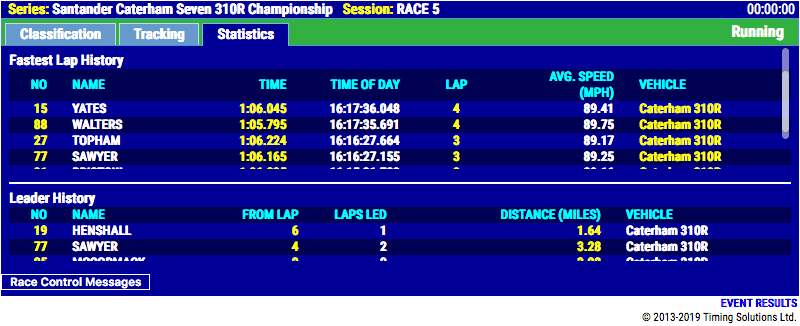

'screenshot_Statistics.png'

In [35]:
getPageByTab(browser, url, 'Statistics')

In [55]:
#get statistics table
#//*[@id="StatsTableContainer"]/div[3]/div[2]/table
xpath = '//*[@id="StatsTableContainer"]/div[3]/div[2]/table'
el = browser.find_element_by_xpath(xpath)
el.text
#'Competitors: 30\nPlanned Start: 15:10\nActual Start: 15:25:00.510\nFinish Time:\nTotal Laps 107\nTotal Distance Covered: 129.2501 mi.\nTrack Length: 1.2079 mi.'

'Competitors: 0\nPlanned Start: 17:40\nActual Start:\nFinish Time:\nTotal Laps 0\nTotal Distance Covered: 0.0000 mi.\nTrack Length: 1.6404 mi.'

In [56]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,0,1
0,Competitors:,0
1,Planned Start:,17:40
2,Actual Start:,NaN
3,Finish Time:,NaN
4,Total Laps,0
5,Total Distance Covered:,0.0000 mi.
6,Track Length:,1.6404 mi.


In [53]:
#Flags table
xpath = '//*[@id="StatsTableContainer"]/div[3]/div[1]/table[1]'
el = browser.find_element_by_xpath(xpath)
el.text
#'COLOUR TOTAL TIME TOTAL LAPS COUNT\nGREEN 00:05:45 5 1\nRED 00:00:29 0 1\nSAFETY CAR 00:00:00 0 0\nFCY 00:00:00 0 0'

'COLOUR TOTAL TIME TOTAL LAPS COUNT\nGREEN 00:00:00 0 0\nRED 00:00:00 0 0\nSAFETY CAR 00:00:00 0 0\nFCY 00:00:00 0 0'

In [54]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,COLOUR,TOTAL TIME,TOTAL LAPS,COUNT
0,GREEN,00:00:00,0,0
1,RED,00:00:00,0,0
2,SAFETY CAR,00:00:00,0,0
3,FCY,00:00:00,0,0


In [50]:
#fastest laps
fastlap_path ='//*[@id="fastestLapTable"]'
el = browser.find_element_by_xpath(fastlap_path)
el.text
#'NO CL NAME TIME TIME OF DAY LAP AVG. SPEED (MPH) VEHICLE\n15\nM\nOLIPHANT * 54.140 15:29:02.984 4 80.32 BMW 330i M Sport\n116\nM\nSUTTON 54.685 15:28:24.626 3 79.52 Subaru Levorg\n25\nM\nNEAL 54.983 15:28:18.112 3 79.08 Honda Civic Type R\n1\nM\nTURKINGTON 55.127 15:28:07.375 3 78.88 BMW 330i M Sport\n303\nI\nSIMPSON 55.228 15:27:58.303 2 78.73 Honda CIvic Type R\n80\nM\nINGRAM 55.449 15:27:17.128 2 78.42 Toyota Corolla\n77\nM\nJORDAN 56.278 15:27:14.039 2 77.27 BMW 330i M Sport\n15\nM\nOLIPHANT * 56.858 15:27:13.242 2 76.48 BMW 330i M Sport\n1\nM\nTURKINGTON 57.049 15:27:12.248 2 76.22 BMW 330i M Sport'

'NO NAME TIME TIME OF DAY LAP AVG. SPEED (MPH) VEHICLE\n21\nLANDY 1:05.695 16:25:25.364 11 89.89 Caterham 310R\n88\nWALTERS 1:05.795 16:17:35.691 4 89.75 Caterham 310R\n74\nBEARDWELL 1:06.112 16:17:35.547 4 89.32 Caterham 310R\n77\nSAWYER 1:06.165 16:16:27.155 3 89.25 Caterham 310R\n91\nBRISTOW 1:06.235 16:15:21.702 2 89.16 Caterham 310R\n77\nSAWYER 1:06.319 16:15:20.980 2 89.04 Caterham 310R\n19\nHENSHALL 1:06.442 16:15:20.364 2 88.88 Caterham 310R'

In [52]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,NO,NAME,TIME,TIME OF DAY,LAP,AVG. SPEED (MPH),VEHICLE
0,21,LANDY,1:05.695,16:25:25.364,11,89.89,Caterham 310R
1,88,WALTERS,1:05.795,16:17:35.691,4,89.75,Caterham 310R
2,74,BEARDWELL,1:06.112,16:17:35.547,4,89.32,Caterham 310R
3,77,SAWYER,1:06.165,16:16:27.155,3,89.25,Caterham 310R
4,91,BRISTOW,1:06.235,16:15:21.702,2,89.16,Caterham 310R
5,77,SAWYER,1:06.319,16:15:20.980,2,89.04,Caterham 310R
6,19,HENSHALL,1:06.442,16:15:20.364,2,88.88,Caterham 310R


In [46]:
#leader history
leaderHistory_path = '//*[@id="leaderHistory"]/div/table'
el = browser.find_element_by_xpath(leaderHistory_path)
el.text
#NO NAME FROM LAP LAPS LED DISTANCE (MILES) VEHICLE\n19\nHENSHALL 6 1 1.64 Caterham 310R\n77\nSAWYER 4 2 3.28 Caterham 310R\n25\nMCCORMACK 2 2 3.28 Caterham 310R\n11\nPERRY 1 1 1.64 Caterham 310R

'NO NAME FROM LAP LAPS LED DISTANCE (MILES) VEHICLE\n77\nSAWYER 9 2 3.28 Caterham 310R\n19\nHENSHALL 8 1 1.64 Caterham 310R\n77\nSAWYER 7 1 1.64 Caterham 310R\n19\nHENSHALL 6 1 1.64 Caterham 310R\n77\nSAWYER 4 2 3.28 Caterham 310R\n25\nMCCORMACK 3 1 1.64 Caterham 310R\n19\nHENSHALL 2 1 1.64 Caterham 310R\n11\nPERRY 1 1 1.64 Caterham 310R'

In [48]:
pd.read_html( '<table>{}</table>'.format(el.get_attribute('innerHTML')))[0].dropna(axis=1,how='all')

,NO,NAME,FROM LAP,LAPS LED,DISTANCE (MILES),VEHICLE
0,77,SAWYER,12,1,1.64,Caterham 310R
1,25,MCCORMACK,11,1,1.64,Caterham 310R
2,77,SAWYER,9,2,3.28,Caterham 310R
3,19,HENSHALL,8,1,1.64,Caterham 310R
4,77,SAWYER,7,1,1.64,Caterham 310R
5,19,HENSHALL,6,1,1.64,Caterham 310R
6,77,SAWYER,4,2,3.28,Caterham 310R
7,25,MCCORMACK,3,1,1.64,Caterham 310R
8,19,HENSHALL,2,1,1.64,Caterham 310R
9,11,PERRY,1,1,1.64,Caterham 310R


screenshot saved to Santander Caterham Seven 310R Championship_RACE 5.png


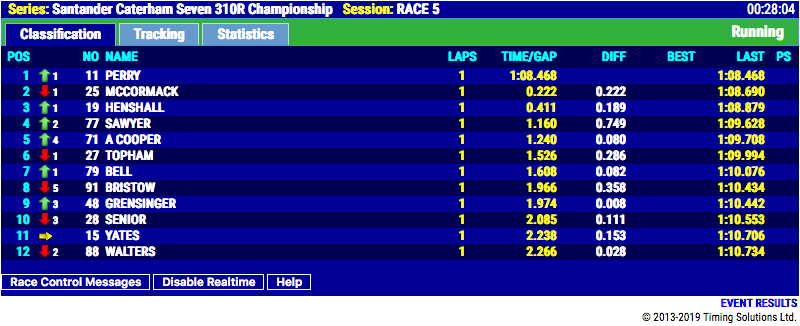

'Santander Caterham Seven 310R Championship_RACE 5.png'

In [24]:
#get file name
fn = '{}_{}.png'.format(series, session )

getPageByTab(browser, url, 'Classification', fn)

In [19]:
#Doesn't work?
trackDisplayName_path ='//*[@id="weatherConditions"]/span[2]'
trackDisplayName = text_value_from_xpath(browser, trackDisplayName_path )
trackDisplayName

''

In [20]:
#Doesn't work?
weatherConditions_xpath = '//*[@id="weatherConditions"]/span[4]'
weatherConditions = text_value_from_xpath(browser, weatherConditions_xpath )
weatherConditions

''

In [21]:
#Doesn't work?
trackConditions_xpath = '//*[@id="weatherConditions"] '
trackConditions = text_value_from_xpath(browser, trackConditions_xpath )
trackConditions

''

## Automated Grab

The aim here is to grab a copy of the screen classification when the race has finished.

(How is finished flagged? Eg if the clock has reached zero do cars get to finish the lap they are on? At what point does "FINISHED" appear?)

*(If we want to run browsers over several timing screens, eg for different meetings on the same day, it may be worth looking to something like https://github.com/micahscopes/nbmultitask so we could launch several watchers, one per timing screen, in separate, non-blocking processes.)*

In [ ]:
#flag status is something like"

#FINISHED
#RUNNING
#RED FLAG
#Scheduled Start: 16.55
#Safety Car

In [57]:
url_brscc = 'https://livetiming.tsl-timing.com/191431'
url_btcc='https://livetiming.tsl-timing.com/191403' #btcc april 6

In [58]:
browser.get(url_btcc)

In [ ]:
import time

#Start to build up the logic

#If we are in a race


race_on = True #if race is running or flagged?
awaiting_result=True

while race_on and awaiting_result:
    
    #Better to use some heuristics here eg based on time left in sessiontime
    #Only issue there is if a race is red flagged so is race clock/sessionTime?
    #So maybe try to grab close race start time, ish, and sessionTime at that point
    #and generate a heuristic about earliest time race is expected to finish?
    time.sleep(5)
    flag = text_value_from_xpath(browser, flag_path )
    
    #carry on waiting
    if flag.upper()=='FINISHED':
        awaiting_result = False
        

fn = '{}_{}.png'.format(series, session )


#Don't need to get the URL? Just dump the screenshot instead?
#Browser is already good and if meeting is busy we may not be able to get a new connection onto timing screen?
#getPageByTab(browser, url, 'Classification', fn)

browser.save_screenshot( fn )

# Emailing the screenshot

Having grabbed the screenshot, we might now want to email it to somebody.

We can do that with the `smtplib` package if we have the details of an SMTP server we can connect to.

For example, if you have a GMail account:

In [44]:
import smtplib, ssl, getpass

port = 465  # For SSL

sender_email = input("Type your GMail address and press enter: ")
sender_password =  getpass.getpass()

# Create a secure SSL context
context = ssl.create_default_context()

receiver_email = "user@example.com"  # Enter receiver address
message = """\
Subject: Test

Test message from code..."""


with smtplib.SMTP_SSL("smtp.gmail.com", port, context=context) as server:
    server.login(sender_email, sender_password)
    server.sendmail(sender_email, receiver_email, message)

Type your GMail address and press enter: *******@gmail.com
········


In [46]:
subject='Test email attachment'
text = """some text
Over several

lines"""


In [50]:
#https://stackoverflow.com/a/3363254/454773
from os.path import basename
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.utils import COMMASPACE, formatdate

def send_mail(server, send_from, send_to, subject, text, files=None):
    assert isinstance(send_to, list)
    assert isinstance(files, list)

    msg = MIMEMultipart()
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    for f in files or []:
        with open(f, "rb") as fo:
            part = MIMEApplication(
                fo.read(),
                Name=basename(f)
            )
        # After the file is closed
        part['Content-Disposition'] = 'attachment; filename="%s"' % basename(f)
        msg.attach(part)


    #smtp = smtplib.SMTP(server)
    smtp = server
    smtp.sendmail(send_from, send_to, msg.as_string())
    smtp.close()


    
server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
server.login(sender_email, sender_password)
send_mail(server, sender_email, [receiver_email], subject, text, files=[outfile])

Sending with image inline as HTML email:

In [51]:
cid = 0 #A unique id count for the image

#We'd probably need to rething this for multiple images...
htmltext=''''<html><body><h1>Timing screen</h1>\n<div><img src="cid:{cid}"></div>\n</body></html>'''.format(cid=cid)

In [76]:
import uuid, datetime
from email.mime.base import MIMEBase
from email import encoders

#ish via https://www.code-learner.com/python-send-html-image-and-attachment-email-example/
def add_image(msg, img, iid=0):
    uniqueId = '{}-{}-{}'.format(img.split('/')[-1], datetime.datetime.now().strftime('%Y%m%d%H%M%S'), uuid.uuid4())
    
    with open(outfile, 'rb') as f:
        # set attachment mime and file name, the image type is png
        mime = MIMEBase('image', 'png', filename=img)
        # add required header data:
        mime.add_header('Content-Disposition', 'attachment', filename=img)
        mime.add_header('X-Attachment-Id', str(iid))
        mime.add_header('Content-ID', '<{}>'.format(iid))
        # read attachment file content into the MIMEBase object
        mime.set_payload(f.read())
        # encode with base64
        encoders.encode_base64(mime)
        # add MIMEBase object to MIMEMultipart object
        msg.attach(mime)
    
def send_mail_html(server, send_from, send_to, subject, text, htmltext, files=None):
    assert isinstance(send_to, list)
    assert isinstance(files, list)

    msg = MIMEMultipart('alternative')
    msg['From'] = send_from
    msg['To'] = COMMASPACE.join(send_to)
    msg['Date'] = formatdate(localtime=True)
    msg['Subject'] = subject

    msg.attach(MIMEText(text))

    fid=0
    for f in files or []:
        add_image(msg, f, fid)
        fid += 1
    msg.attach(MIMEText(htmltext, 'html', 'utf-8'))


    #smtp = smtplib.SMTP(server)
    smtp = server
    smtp.sendmail(send_from, send_to, msg.as_string())
    smtp.close()
    


In [77]:
server = smtplib.SMTP_SSL("smtp.gmail.com", port, context=context)
server.login(sender_email, sender_password)
send_mail_html(server, sender_email, [receiver_email], subject, text, htmltext, files=[outfile])

## TO DO

On the emailer:

- tidy it up so there's a reasonable way of adding multiple images to HTML email and getting the IDs right...

On the screengrabber:

- keep checking the page, parsing it to look for when a session is complete, then send an email of the final classification etc.

*I'm not sure if this would require reloading the page or whether the socket connection to the live timing server works and selenium can just keep rechecking for when a particular id takes a `FINISHED` value?*